In [1]:
import numpy as np
import matplotlib.pyplot as plt
from testCases import *
import sklearn
import sklearn.datasets
import sklearn.linear_model
from planar_utils import plot_decision_boundary, sigmoid, load_planar_dataset, load_extra_datasets

np.random.seed(1) # set a seed so that the results are consistent

## code of load_planar_dataset:
```python
def load_planar_dataset():
    np.random.seed(1)
    m = 400 # number of examples
    N = int(m/2) # number of points per class
    D = 2 # dimensionality
    X = np.zeros((m,D)) # data matrix where each row is a single example
    Y = np.zeros((m,1), dtype='uint8') # labels vector (0 for red, 1 for blue)
    a = 4 # maximum ray of the flower

    for j in range(2):
        ix = range(N*j,N*(j+1))
        t = np.linspace(j*3.12,(j+1)*3.12,N) + np.random.randn(N)*0.2 # theta
        r = a*np.sin(4*t) + np.random.randn(N)*0.2 # radius
        X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
        Y[ix] = j
        
    X = X.T
    Y = Y.T

    return X, Y
```

As we could see, this def plot some function in polar coordinates in two adjacnet regions, then use `np.c_` to cenvert it into Cartesian coordinate.

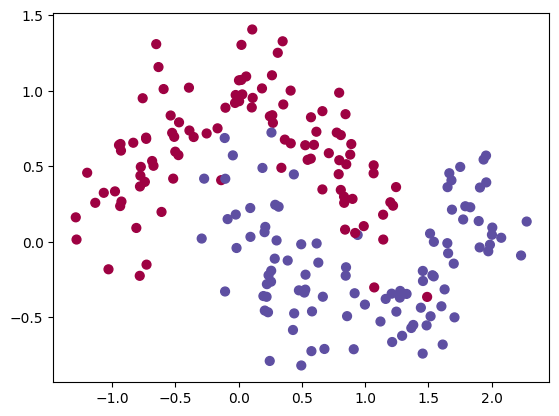

In [2]:
# Datasets
noisy_circles, noisy_moons, blobs, gaussian_quantiles, no_structure = load_extra_datasets()

datasets = {"noisy_circles": noisy_circles,
            "noisy_moons": noisy_moons,
            "blobs": blobs,
            "gaussian_quantiles": gaussian_quantiles}

### START CODE HERE ### (choose your dataset)
dataset = "noisy_moons"
### END CODE HERE ###

X, Y = datasets[dataset]
X, Y = X.T, Y.reshape(1, Y.shape[0])

# make blobs binary
if dataset == "blobs":
    Y = Y%2

# Visualize the data
plt.scatter(X[0, :], X[1, :], c=Y, s=40, cmap=plt.cm.Spectral);

## Simple examples for sklearn

Accuracy of logistic regression: 86 % (percentage of correctly labelled datapoints)


d:\software\anaconda3\envs\deepL\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


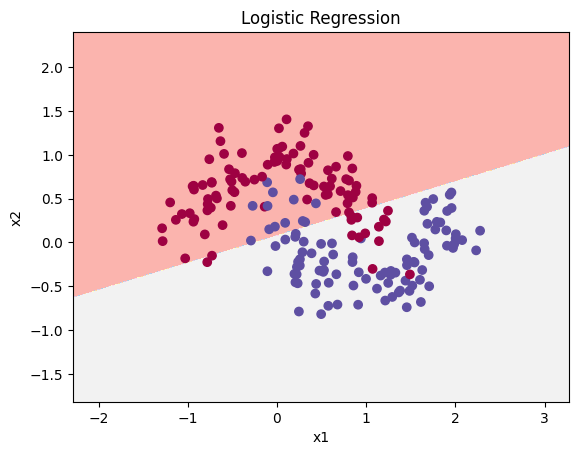

In [3]:
# Train the logistic regression classifier
clf = sklearn.linear_model.LogisticRegressionCV();
clf.fit(X.T, Y.T);

# Plot the decision boundary for logistic regression
plot_decision_boundary(lambda x: clf.predict(x), X, Y)
plt.title("Logistic Regression")

# Print accuracy
LR_predictions = clf.predict(X.T)
print ('Accuracy of logistic regression: %d ' % float((np.dot(Y,LR_predictions) + np.dot(1-Y,1-LR_predictions))/float(Y.size)*100) +
       '% ' + "(percentage of correctly labelled datapoints)")

In [4]:
def layer_sizes(X, Y):

    n_x = X.shape[0]
    n_h = 4
    n_y = Y.shape[0]

    return n_x, n_h, n_y

X_assess, Y_assess = layer_sizes_test_case()
n_x, n_h, n_y = layer_sizes(X_assess, Y_assess)
print("The size of the input layer is: n_x = " + str(n_x))
print("The size of the hidden layer is: n_h = " + str(n_h))
print("The size of the output layer is: n_y = " + str(n_y))

The size of the input layer is: n_x = 5
The size of the hidden layer is: n_h = 4
The size of the output layer is: n_y = 2


In [5]:
def initialize_parameters(n_x, n_h, n_y):

    W1 = np.random.randn(n_h, n_x)
    b1 = np.zeros((n_h, 1))

    W2 = np.random.randn(n_y, n_h)
    b2 = np.zeros((n_y, 1))
    
    assert (W1.shape == (n_h, n_x))
    assert (b1.shape == (n_h, 1))
    assert (W2.shape == (n_y, n_h))
    assert (b2.shape == (n_y, 1))
    
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2}
    
    return parameters

n_x, n_h, n_y = initialize_parameters_test_case()

parameters = initialize_parameters(n_x, n_h, n_y)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[ 1.14472371  0.90159072]
 [ 0.50249434  0.90085595]
 [-0.68372786 -0.12289023]
 [-0.93576943 -0.26788808]]
b1 = [[0.]
 [0.]
 [0.]
 [0.]]
W2 = [[ 0.53035547 -0.69166075 -0.39675353 -0.6871727 ]]
b2 = [[0.]]


## Some equation for backward propagation with multiple hidden layers:

$$ dZ^{[l]} = dA^{[l]} \times g'^{[l]} (Z^{[l]}) $$
$$ dW^{[l]} = \frac{1}{m} dZ^{[l]} A^{[l-1] T} $$
$$ db^{[l]} = \frac{1}{m} np.sum(dZ^{[l]}, \text{axis} = 1, \text{keepdims} = \text{True}) $$
$$ dA^{[l-1]} = W^{[l] T} dZ^{[l]} $$

for model with one hidden layer, we have:

$$ dZ^{[2]} = dA^{[2]} \times g'^{[2]} (Z^{[2]}) = A^{[2]} - Y $$
$$ dW^{[2]} = \frac{1}{m} dZ^{[2]} A^{[1]T} = (A^{[2]} - Y)A^{[1]T} $$
$$ db^{[2]} = \frac{1}{m} np.sum(A^{[2]} - Y, \text{axis} = 1)$$

$$ dA^{[1]} = W^{[2] T} dZ^{[2]} $$
$$ dZ^{[1]} = W^{[2] T} dZ^{[2]} \times g'^{[1]} (Z^{[1]}) $$



In [6]:
def forward_propagation(X, parameters):
    
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]

    Z1 = np.dot(W1, X) + b1
    A1 = np.tanh(Z1)

    Z2 = np.dot(W2, A1) + b2
    A2 = sigmoid(Z2)

    assert(A2.shape == (1, X.shape[1]))

    cache = {"Z1": Z1,
             "A1": A1,
             "Z2": Z2,
             "A2": A2}
    
    return A2, cache

X_assess, parameters = forward_propagation_test_case()

A2, cache = forward_propagation(X_assess, parameters)

# Note: we use the mean here just to make sure that your output matches ours. 
print(np.mean(cache['Z1']) ,np.mean(cache['A1']),np.mean(cache['Z2']),np.mean(cache['A2']))

    

-0.0004997557777419902 -0.000496963353231779 0.0004381874509591466 0.500109546852431


## Cost function

$$ J = - \frac{1}{m} \sum\limits_{i = 0}^{m} \large{(} \small y^{(i)}\log\left(a^{[2] (i)}\right) + (1-y^{(i)})\log\left(1- a^{[2] (i)}\right) \large{)} $$

**Notice:**
The cost function only depends on $A^{[2]}$.

In [7]:
def compute_cost(A2, Y, parameters):

    m = Y.shape[1]
    cost = None


    cost = -(1 / m) * (np.dot(Y, np.log(A2).T) + np.dot(1 - Y, np.log(1 - A2).T))

    cost = np.squeeze(cost)


    return cost

def compute_cost1(A2, Y, parameters):
    m = Y.shape[1]
    cost = None


    logprobs = np.multiply(np.log(A2), Y) + np.multiply(np.log(1-A2), 1-Y)
    cost = -np.sum(logprobs) / m

    cost = np.squeeze(cost)


    return cost

A2, Y_assess, parameters = compute_cost_test_case()

print("cost = " + str(compute_cost(A2, Y_assess, parameters)))
print("cost = " + str(compute_cost1(A2, Y_assess, parameters)))



cost = 0.6929198937761265
cost = 0.6929198937761266


In [8]:
def backward_propagation(parameters, cache, X, Y):

    m = X.shape[1]

    W1 = parameters["W1"]
    W2 = parameters["W2"]

    A1 = cache["A1"]
    A2 = cache["A2"]

    dZ2 = A2 - Y
    dW2 = (1/m) * np.dot(dZ2, A1.T)
    db2 = (1/m) * np.sum(dZ2, axis = 1, keepdims = True)

    dZ1 = np.multiply(np.dot(W2.T, dZ2), (1 - np.power(A1, 2)))
    dW1 = (1/m) * np.dot(dZ1, X.T)
    db1 = (1/m) * np.sum(dZ1, axis = 1, keepdims = True)

    grads = {"dW1": dW1,
            "db1": db1,
            "dW2": dW2,
            "db2": db2}
    
    return grads

parameters, cache, X_assess, Y_assess = backward_propagation_test_case()

grads = backward_propagation(parameters, cache, X_assess, Y_assess)
print ("dW1 = "+ str(grads["dW1"]))
print ("db1 = "+ str(grads["db1"]))
print ("dW2 = "+ str(grads["dW2"]))
print ("db2 = "+ str(grads["db2"]))

dW1 = [[ 0.01018708 -0.00708701]
 [ 0.00873447 -0.0060768 ]
 [-0.00530847  0.00369379]
 [-0.02206365  0.01535126]]
db1 = [[-0.00069728]
 [-0.00060606]
 [ 0.000364  ]
 [ 0.00151207]]
dW2 = [[ 0.00363613  0.03153604  0.01162914 -0.01318316]]
db2 = [[0.06589489]]


In [9]:
def update_parameters(parameters, grads, learning_rate = 1.2):
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]

    dW1 = grads["dW1"]
    dW2 = grads["dW2"]
    db1 = grads["db1"]
    db2 = grads["db2"]

    W1 = W1 - learning_rate * dW1
    W2 = W2 - learning_rate * dW2
    b1 = b1 - learning_rate * db1
    b2 = b2 - learning_rate * db2

    parameters = {"W1": W1,
                "b1": b1,
                "W2": W2,
                "b2": b2}
    
    return parameters


parameters, grads = update_parameters_test_case()
parameters = update_parameters(parameters, grads)

print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))

W1 = [[-0.00643025  0.01936718]
 [-0.02410458  0.03978052]
 [-0.01653973 -0.02096177]
 [ 0.01046864 -0.05990141]]
b1 = [[-1.02420756e-06]
 [ 1.27373948e-05]
 [ 8.32996807e-07]
 [-3.20136836e-06]]
W2 = [[-0.01041081 -0.04463285  0.01758031  0.04747113]]
b2 = [[0.00010457]]


In [10]:
def nn_model(X, Y, n_h, num_iterations = 10000, print_cost=False):

    np.random.seed(3)
    n_x = layer_sizes(X, Y)[0]
    n_y = layer_sizes(X, Y)[2]

    parameters = initialize_parameters(n_x, n_h, n_y)
    W1 = parameters["W1"]
    W2 = parameters["W2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]

    for i in range(0, num_iterations):
        A2, cache = forward_propagation(X, parameters)

        cost = compute_cost(A2, Y, parameters)

        grads = backward_propagation(parameters, cache, X, Y)

        parameters = update_parameters(parameters, grads)

        if print_cost and i % 1000 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))

    return parameters

X_assess, Y_assess = nn_model_test_case()

parameters = nn_model(X_assess, Y_assess, 4, num_iterations=10000, print_cost=True)
print("W1 = " + str(parameters["W1"]))
print("b1 = " + str(parameters["b1"]))
print("W2 = " + str(parameters["W2"]))
print("b2 = " + str(parameters["b2"]))
    

Cost after iteration 0: 0.770370
Cost after iteration 1000: -inf


Cost after iteration 2000: -inf
Cost after iteration 3000: -inf
Cost after iteration 4000: -inf
Cost after iteration 5000: -inf
Cost after iteration 6000: -inf


d:\software\anaconda3\envs\deepL\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: divide by zero encountered in log
  import sys
c:\sciencificcomputation\code\deeplearning\learning\week3\planar_utils.py:34: RuntimeWarning: overflow encountered in exp
  s = 1/(1+np.exp(-x))


Cost after iteration 7000: -inf
Cost after iteration 8000: -inf
Cost after iteration 9000: -inf
W1 = [[ 7.53831683 -1.20772519]
 [ 3.74341408 -5.77858313]
 [-7.53831138  1.20773002]
 [ 4.14296415 -5.36353386]]
b1 = [[-3.81051705]
 [-2.20590894]
 [ 3.81053144]
 [-2.32782142]]
W2 = [[ 6011.30162343  6036.36128506 -6011.30712283  6037.28968508]]
b2 = [[-53.03525576]]


In [11]:
def predict(parameters, X):

    A2, cache = forward_propagation(X, parameters)
    predict = (A2 > 0.5)

    return predict

parameters, X_assess = predict_test_case()

predictions = predict(parameters, X_assess)
print("predictions mean = " + str(np.mean(predictions)))

predictions mean = 0.6666666666666666


## Some explanation about `lambda`:

```python
lambda argument_list:expression
```

Cost after iteration 0: 0.745995
Cost after iteration 1000: 0.097125
Cost after iteration 2000: 0.094756
Cost after iteration 3000: 0.094004
Cost after iteration 4000: 0.093567
Cost after iteration 5000: 0.093486
Cost after iteration 6000: 0.093701
Cost after iteration 7000: 0.093544
Cost after iteration 8000: 0.093352
Cost after iteration 9000: 0.093106


Text(0.5, 1.0, 'Decision Boundary for hidden layer size 4')

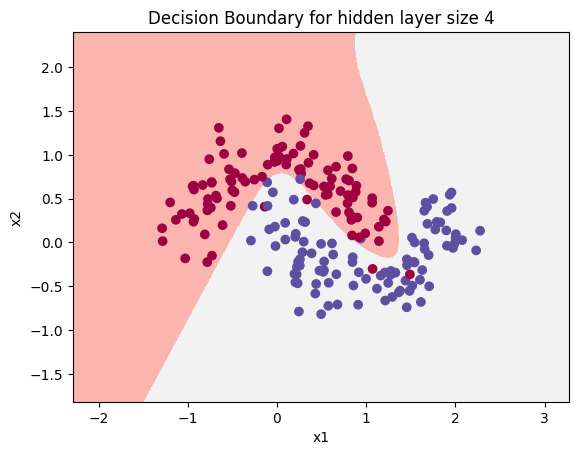

In [12]:
# Build a model with a n_h-dimensional hidden layer
parameters = nn_model(X, Y, n_h = 4, num_iterations = 10000, print_cost=True)

# Plot the decision boundary
plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
plt.title("Decision Boundary for hidden layer size " + str(4))

In [13]:
# Print accuracy
predictions = predict(parameters, X)

print (predictions.shape)
print (np.dot(Y,predictions.T).shape)
print (np.dot(1-Y,1-predictions.T).shape)
print ('Accuracy: %d' % float((np.dot(Y,predictions.T)[0,0] + np.dot(1-Y,1-predictions.T)[0,0])/float(Y.size)*100) + '%')

(1, 200)
(1, 1)
(1, 1)
Accuracy: 97%


Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 86.5 %
Accuracy for 3 hidden units: 97.0 %
Accuracy for 4 hidden units: 96.5 %
Accuracy for 5 hidden units: 96.0 %
Accuracy for 20 hidden units: 96.5 %
Accuracy for 50 hidden units: 97.0 %
Accuracy for 70 hidden units: 96.5 %


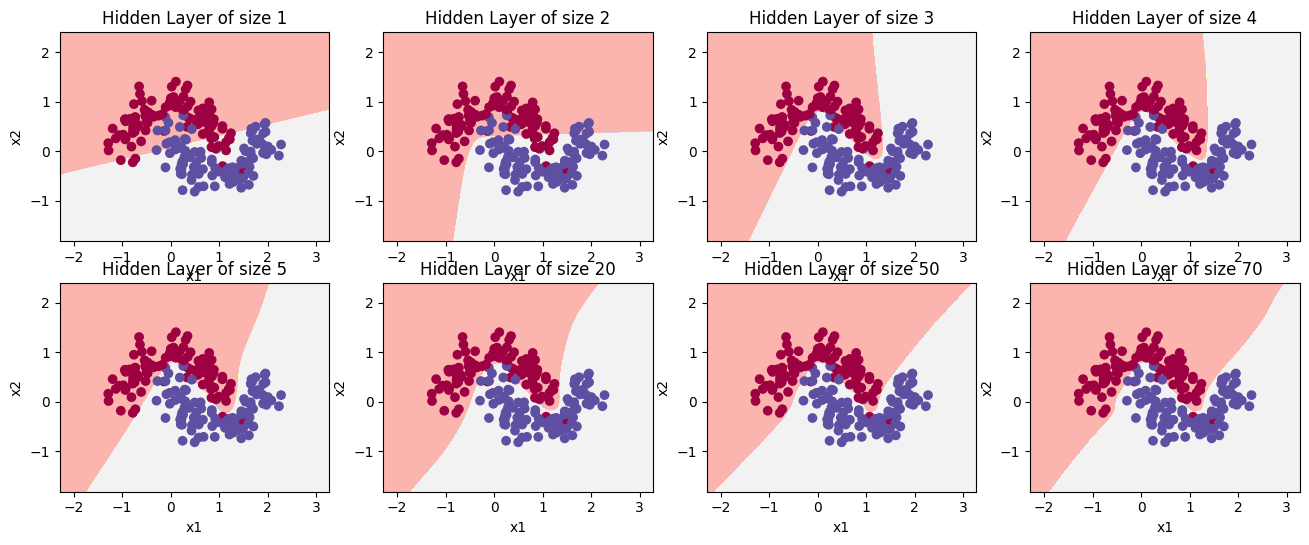

In [21]:
# This may take about 2 minutes to run

plt.figure(figsize=(16, 32))
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50, 70]
for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(10, 4, i+1)
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations = 5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y,predictions.T)[0,0] + np.dot(1-Y,1-predictions.T)[0,0])/float(Y.size)*100)
    print ("Accuracy for {} hidden units: {} %".format(n_h, accuracy))

Accuracy for 1 hidden units: 86.0 %
Accuracy for 2 hidden units: 86.5 %
Accuracy for 3 hidden units: 97.0 %
Accuracy for 4 hidden units: 96.5 %
Accuracy for 5 hidden units: 96.0 %
Accuracy for 20 hidden units: 96.5 %
Accuracy for 50 hidden units: 97.0 %
Accuracy for 70 hidden units: 96.5 %


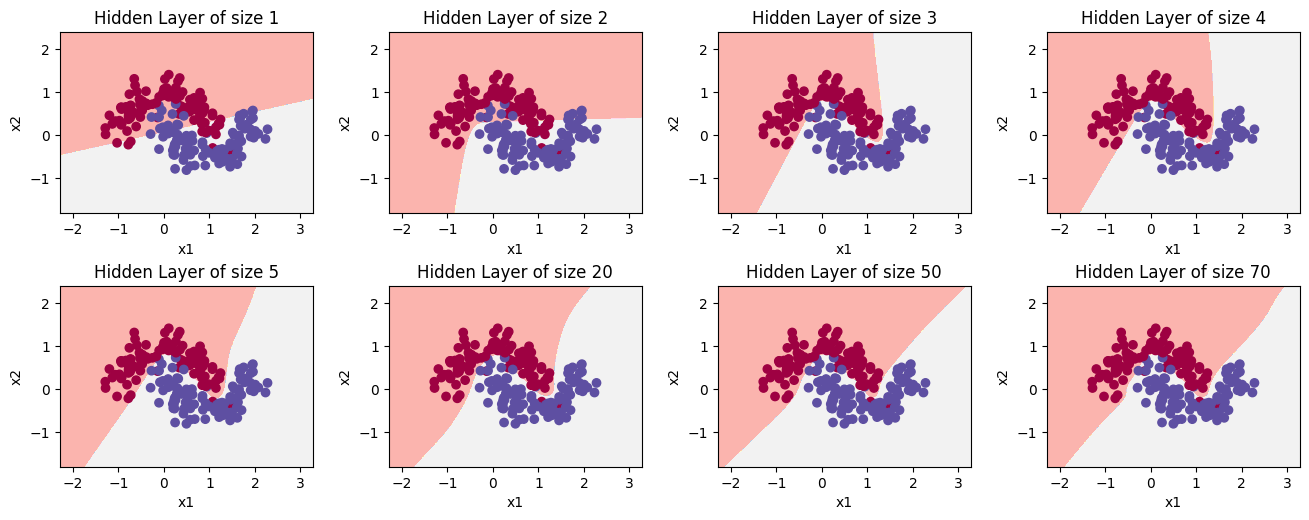

In [25]:
plt.figure(figsize=(16, 32))  # You can adjust the figure size if needed
hidden_layer_sizes = [1, 2, 3, 4, 5, 20, 50, 70]

# Use subplots_adjust to add more space between the plots
plt.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust vertical spacing (hspace)

for i, n_h in enumerate(hidden_layer_sizes):
    plt.subplot(10, 4, i+1)  # Adjust the grid size if needed
    plt.title('Hidden Layer of size %d' % n_h)
    parameters = nn_model(X, Y, n_h, num_iterations=5000)
    plot_decision_boundary(lambda x: predict(parameters, x.T), X, Y)
    predictions = predict(parameters, X)
    accuracy = float((np.dot(Y, predictions.T) + np.dot(1-Y, 1-predictions.T))/float(Y.size)*100)
    print("Accuracy for {} hidden units: {} %".format(n_h, accuracy))